# Imports

In [1]:
%pip install scikit-learn xgboost imbalanced-learn

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# df_trn = pd.read_csv("../data/guiDataCleanInfill0Treino.csv")
# df_tst = pd.read_csv("../data/guiDataCleanInfill0Teste.csv")

# df_trn = pd.read_csv("../data/guiDataCleanKNNTreino.csv")
# df_tst = pd.read_csv("../data/guiDataCleanKNNTeste.csv")

df_trn = pd.read_csv("../data/guiDataCleanMaxDataTreino.csv")
df_tst = pd.read_csv("../data/guiDataCleanMaxDataTeste.csv")

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Dividir X e y
X_train, y_train = df_trn.drop('nr_abandono', axis=1), df_trn['nr_abandono']
X_test, y_test = df_tst.drop('nr_abandono', axis=1), df_tst['nr_abandono']

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scaling
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [3]:
# usar RandomizedSearchCV para encontrar os melhores hiperparâmetros
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}
cv = 5  # número de folds para validação cruzada
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=150,
    scoring='roc_auc',
    cv=cv,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_resampled_scaled, y_train_resampled)

# Previsões e resultados
y_pred = random_search.predict(X_test_scaled)

#melhores parametros encontrados recall, roc_auc, precision, f1
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("Melhor score de validação (ROC AUC):")
print(random_search.best_score_)
from sklearn.metrics import classification_report, confusion_matrix
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred))



/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fo

Melhores parâmetros encontrados:
{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.8}
Melhor score de validação (ROC AUC):
0.9995555555555555
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.93      0.93      0.93        14

    accuracy                           0.96        46
   macro avg       0.95      0.95      0.95        46
weighted avg       0.96      0.96      0.96        46

Matriz de confusão:
[[31  1]
 [ 1 13]]


In [4]:
# Salvar o modelo treinado e seu respectivo scaler para uso futuro e comparação
import joblib
joblib.dump(random_search.best_estimator_, 'xgb_max_data.pkl')
joblib.dump(scaler, 'scaler_max_data.pkl')

['scaler_max_data.pkl']

In [5]:
# verificar overfitting se ocorreu overfitting
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train_resampled, random_search.predict(X_train_resampled_scaled))
test_auc = roc_auc_score(y_test, y_pred)
print(f"AUC no conjunto de treino: {train_auc:.4f}")
print(f"AUC no conjunto de teste: {test_auc:.4f}")
# salvar o modelo treinado
import joblib
joblib.dump(random_search, 'xgb_max_data.pkl')



AUC no conjunto de treino: 0.9966
AUC no conjunto de teste: 0.9487


['xgb_max_data.pkl']

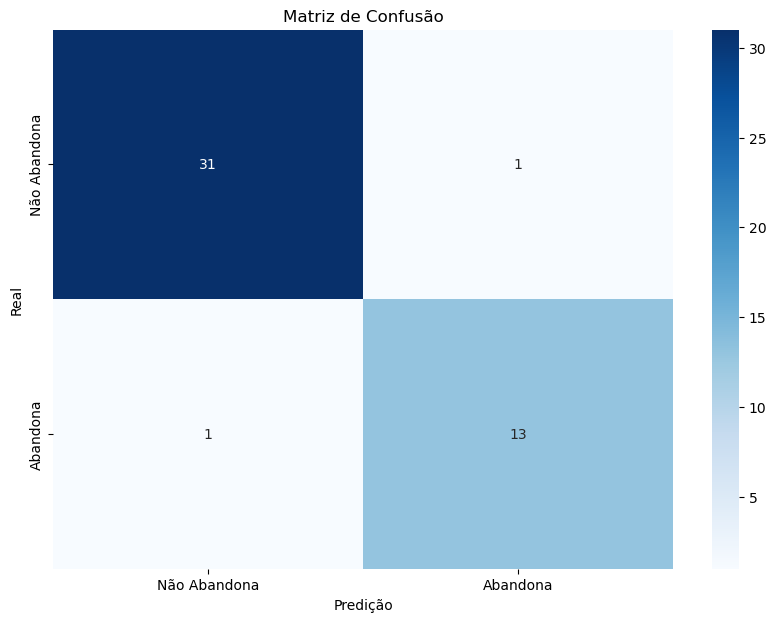

In [6]:
# visualizar os resultados
import matplotlib.pyplot as plt
import seaborn as sns
# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Abandona', 'Abandona'], yticklabels=['Não Abandona', 'Abandona'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()



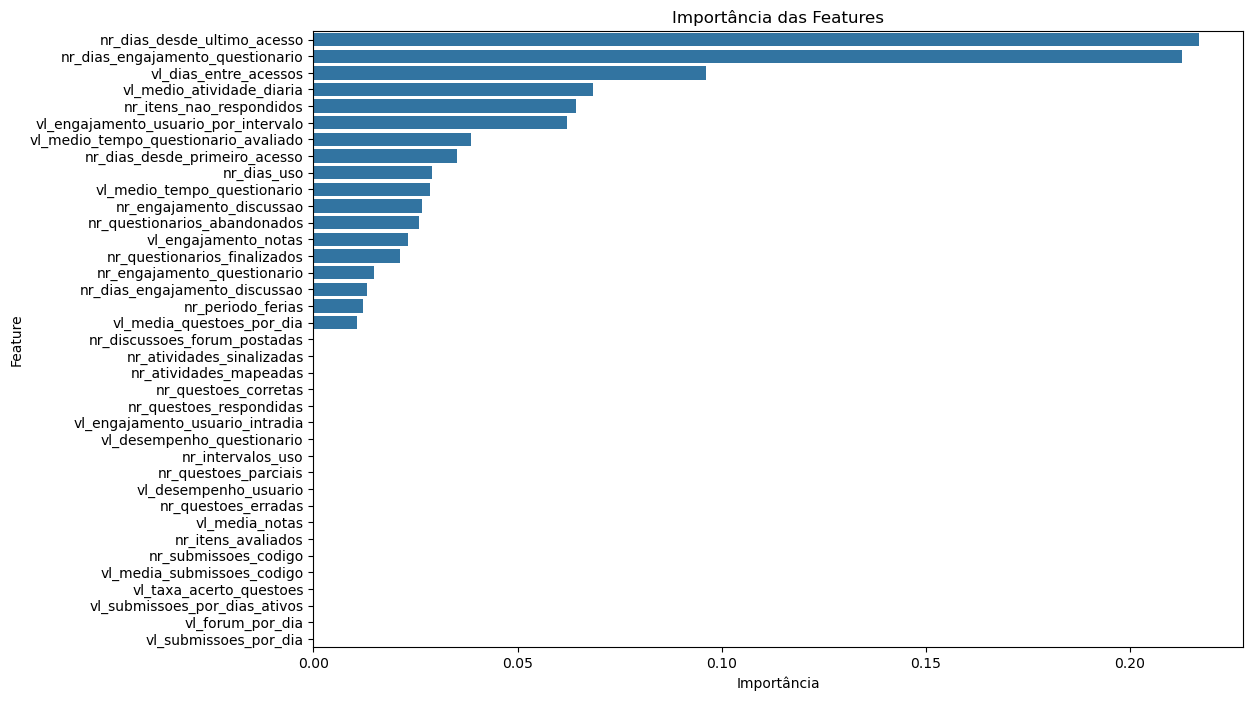

In [7]:
# visualizar importancia das features com nomes
importances = random_search.best_estimator_.feature_importances_
feature_names = X_train.columns
# Criar um DataFrame para as importâncias
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Ordenar por importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotar as importâncias
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()




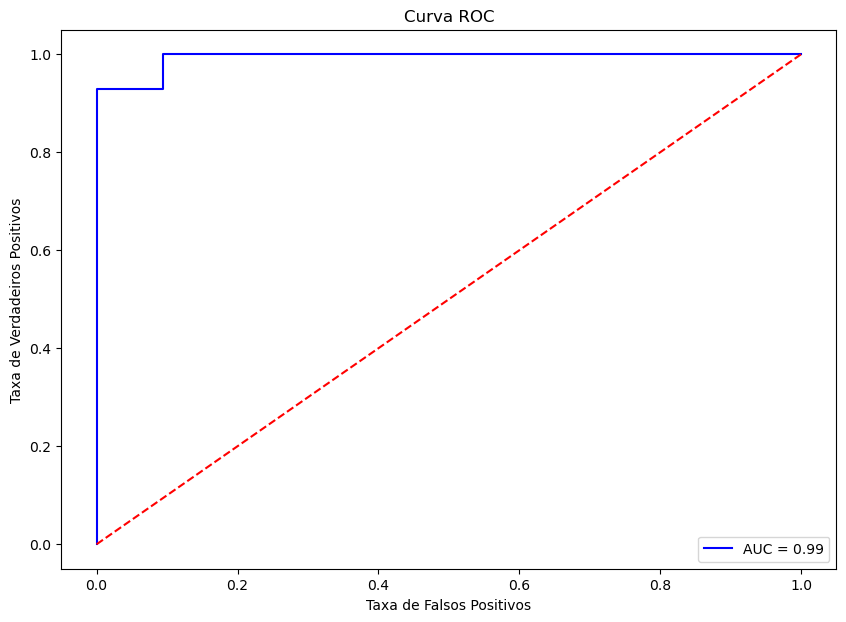

In [8]:
# Plotar a curva ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, random_search.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label='AUC = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.show()


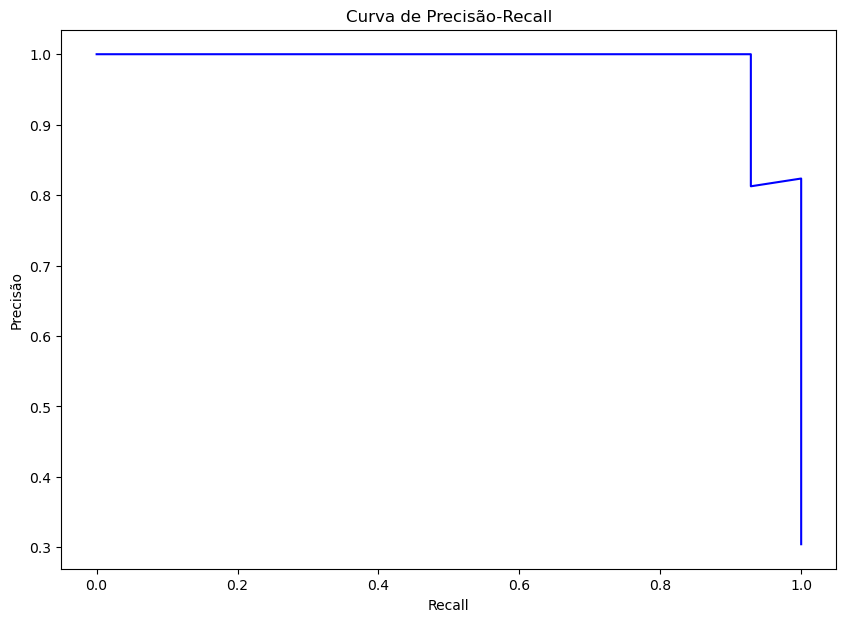

In [9]:
# Plotar a curva de precisão-recall
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, random_search.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='blue')
plt.title('Curva de Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()


/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/zgui/miniconda3/envs/projeto-ia/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fo

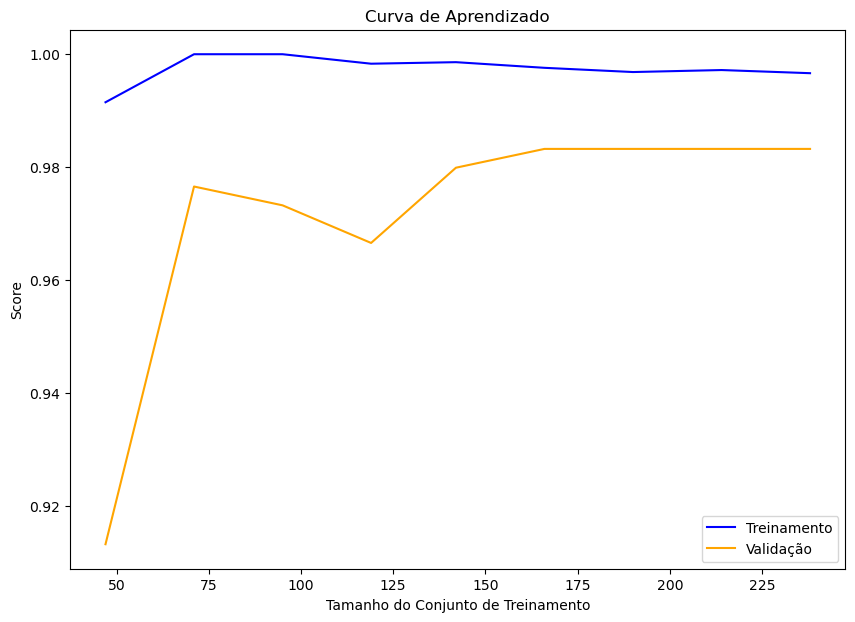

In [10]:
# Plotar a curva de aprendizado
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    random_search.best_estimator_, X_train_resampled_scaled, y_train_resampled,
    cv=cv, n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
plt.figure(figsize=(10, 7))
plt.plot(train_sizes, train_scores_mean, label='Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validação', color='orange')
plt.title('Curva de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Score')
plt.legend()
plt.show()

In [11]:
# salvar metricas de desempenho para comparação futura, recall, roc_auc, precision, f1
metrics = {
    'best_params': random_search.best_params_,
    'best_score': random_search.best_score_,
    'train_auc': train_auc,
    'test_auc': test_auc,
    'classification_report': classification_report(y_test, y_pred, output_dict=True)
}
import json
with open('metrics_max_data.json', 'w') as f:
    json.dump(metrics, f, indent=4)



In [ ]:
dudugay